<a href="https://colab.research.google.com/github/mfz/fastbook/blob/master/My_multicat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! curl -s https://course.fast.ai/setup/colab | bash
! pip install fastai2
! pip install nbdev
! pip install azure-cognitiveservices-search-imagesearch


# Numpy and pandas by default assume a narrow screen - this fixes that
from fastai2.vision.all import *
from nbdev.showdoc import *
from ipywidgets import widgets
from pandas.api.types import CategoricalDtype

import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 200
mpl.rcParams['savefig.dpi']= 200
mpl.rcParams['font.size']=12

set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
pd.set_option('display.max_columns',999)
np.set_printoptions(linewidth=200)
torch.set_printoptions(linewidth=200)


# multicat

Look at multi-label classification, where we have zero or multiple objects in an image (before we assigned each picture to one category only, albeit probabilistically) 

In [2]:
path = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


Now create a DataBlock from the dataframe.

Use get_x and get_y to extract x and y from data frame.

Use ImageBlock, MultiCategoryBlock to convert x to image and y to multicategory.

Use splitter to provide indices for training and validation data set

In [0]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

dblock = DataBlock(blocks = [ImageBlock, MultiCategoryBlock],
                   get_x = lambda r: path/'train'/r['fname'],
                   get_y = lambda r: r['labels'].split(),
                   splitter = splitter,
                   item_tfms = RandomResizedCrop(128, min_scale = 0.35))
dsets = dblock.datasets(df)

In [10]:
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [0]:
dls = dblock.dataloaders(df)

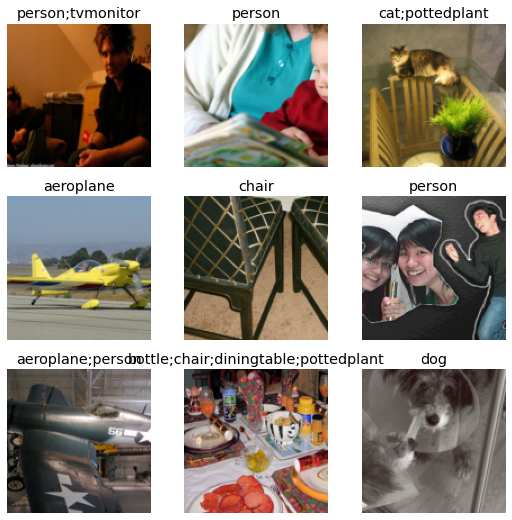

In [12]:
dls.show_batch()

In [18]:
learn = cnn_learner(dls, resnet18, metrics = partial(accuracy_multi, thresh = 0.6))
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

BCEWithLogitsLoss is class version of function below.

Note: instead of softmax, we use sigmoid, as we do not want to normalize the sum of probs to 1


In [0]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).log().mean()

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.033113110810518265)

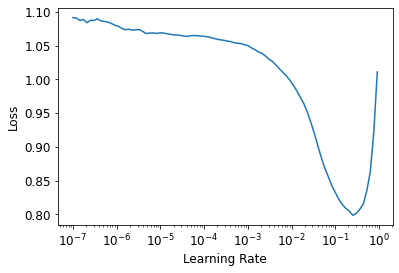

In [15]:
learn.lr_find()

In [0]:
accuracy_multi??


In [19]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.922118,0.632592,0.780558,00:34


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.719783,0.518717,0.866534,00:34
1,0.581302,0.354102,0.938207,00:34
2,0.481081,0.313368,0.946076,00:35


# regression

Instead of doing classification, we can also do regression, i.e. y is continuous.

In [0]:
path = untar_data(URLs.PASCAL)